# Sambhav Agrawal 19264 Data Science and Engineering

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage
from skimage import measure, color, io

img = cv2.imread("/content/tounching_grayscale.png")
#Extract only blue channel as DAPI / nuclear (blue) staining is the best
#channel to perform cell count.
cells=img[:,:,0]  #Blue channel. Image equivalent to grey image.


pixels_to_um = 0.454 # 1 pixel = 454 nm (got this from the metadata of original image)

#Threshold image to binary using OTSU. ALl thresholded pixels will be set to 255
ret1, thresh = cv2.threshold(cells, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)


# Morphological operations to remove small noise - opening
#To remove holes we can use closing
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

from skimage.segmentation import clear_border
opening = clear_border(opening) #Remove edge touching grains
#Check the total regions found before and after applying this. 

#Now we know that the regions at the center of cells is for sure cells
#The region far away is background.
#We need to extract sure regions. For that we can use erode. 
#But we have cells touching, so erode alone will not work. 
#To separate touching objects, the best approach would be distance transform and then thresholding.

# let us start by identifying sure background area
# dilating pixes a few times increases cell boundary to background. 
# This way whatever is remaining for sure will be background. 
#The area in between sure background and foreground is our ambiguous area. 
#Watershed should find this area for us. 
sure_bg = cv2.dilate(opening,kernel,iterations=10)

# Finding sure foreground area using distance transform and thresholding
#intensities of the points inside the foreground regions are changed to 
#distance their respective distances from the closest 0 value (boundary).
#https://www.tutorialspoint.com/opencv/opencv_distance_transformation.htm
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)


#Let us threshold the dist transform by starting at 1/2 its max value.
#print(dist_transform.max()) gives about 21.9
ret2, sure_fg = cv2.threshold(dist_transform,0.5*dist_transform.max(),255,0)

#Later you realize that 0.25* max value will not separate the cells well.
#High value like 0.7 will not recognize some cells. 0.5 seems to be a good compromize

# Unknown ambiguous region is nothing but bkground - foreground
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

#Now we create a marker and label the regions inside. 
# For sure regions, both foreground and background will be labeled with positive numbers.
# Unknown regions will be labeled 0. 
#For markers let us use ConnectedComponents. 
ret3, markers = cv2.connectedComponents(sure_fg)

#One problem rightnow is that the entire background pixels is given value 0.
#This means watershed considers this region as unknown.
#So let us add 10 to all labels so that sure background is not 0, but 10
markers = markers+10

# Now, mark the region of unknown with zero
markers[unknown==255] = 0
#plt.imshow(markers, cmap='jet')   #Look at the 3 distinct regions.

#Now we are ready for watershed filling. 
markers = cv2.watershed(img,markers)
#The boundary region will be marked -1
#https://docs.opencv.org/3.3.1/d7/d1b/group__imgproc__misc.html#ga3267243e4d3f95165d55a618c65ac6e1

#Let us color boundaries in yellow. 
img[markers == -1] = [0,255,255]  

img2 = color.label2rgb(markers, bg_label=0)

#cv2.imshow('Overlay on original image', img)
#cv2.imshow('Colored Grains', img2)
#cv2.waitKey(0)

#Now, time to extract properties of detected cells
# regionprops function in skimage measure module calculates useful parameters for each object.
regions = measure.regionprops(markers, intensity_image=cells)

#Can print various parameters for all objects
for prop in regions:
    print('Label: {} Area: {}'.format(prop.label, prop.area))

#Best way is to output all properties to a csv file
#Let us pick which ones we want to export. 

propList = ['Area',
            'equivalent_diameter', #Added... verify if it works
            'orientation', #Added, verify if it works. Angle btwn x-axis and major axis.
            'MajorAxisLength',
            'MinorAxisLength',
            'Perimeter',
            'MinIntensity',
            'MeanIntensity',
            'MaxIntensity']    
    

output_file = open('cell_measurements.csv', 'w')
output_file.write(',' + ",".join(propList) + '\n') #join strings in array by commas, leave first cell blank
#First cell blank to leave room for header (column names)

for region_props in regions:
    #output cluster properties to the excel file
    output_file.write(str(region_props['Label']))
    for i,prop in enumerate(propList):
        if(prop == 'Area'): 
            to_print = region_props[prop]*pixels_to_um**2   #Convert pixel square to um square
        elif(prop == 'orientation'): 
            to_print = region_props[prop]*57.2958  #Convert to degrees from radians
        elif(prop.find('Intensity') < 0):          # Any prop without Intensity in its name
            to_print = region_props[prop]*pixels_to_um
        else: 
            to_print = region_props[prop]     #Reamining props, basically the ones with Intensity in its name
        output_file.write(',' + str(to_print))
    output_file.write('\n')

Label: 10 Area: 17058
Label: 11 Area: 705
Label: 12 Area: 760
Label: 13 Area: 669
Label: 14 Area: 1946
Label: 15 Area: 603
Label: 16 Area: 679
Label: 17 Area: 456
Label: 18 Area: 545


In [2]:
# import the necessary packages
from __future__ import print_function
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage
import argparse
import imutils
import cv2

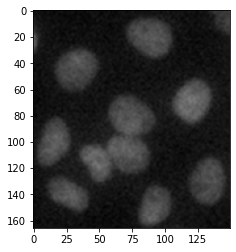

In [9]:
img = cv2.imread('/content/tounching_grayscale.png')

shifted = cv2.pyrMeanShiftFiltering(img, 21, 51)
plt.imshow(img)

[INFO] 10 unique contours found


-1

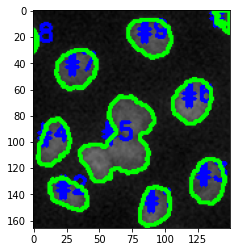

In [10]:
# find contours in the thresholded image
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
print("[INFO] {} unique contours found".format(len(cnts)))
# loop over the contours
for (i, c) in enumerate(cnts):
	# draw the contour
	((x, y), _) = cv2.minEnclosingCircle(c)
	cv2.putText(img, "#{}".format(i + 1), (int(x) - 10, int(y)),
		cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
	cv2.drawContours(img, [c], -1, (0, 255, 0), 2)
# show the output image
plt.imshow(img)
cv2.waitKey(0)

[INFO] 17 unique segments found


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/usr/local/lib/python3.7/dist-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


-1

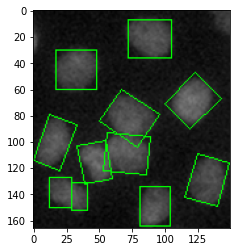

In [12]:
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage
import numpy as np
import cv2


# load the image and perform pyramid mean shift filtering
# to aid the thresholding step
image = cv2.imread('/content/tounching_grayscale.png')
shifted = cv2.pyrMeanShiftFiltering(image, 41, 51)

# convert the mean shift image to grayscale, then apply
# Otsu's thresholding
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255,
    cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
im = gray.copy()    
D = ndimage.distance_transform_edt(thresh)
localMax = peak_local_max(D, indices=False, min_distance=3,  
    labels=thresh)
# perform a connected component analysis on the local peaks,
# using 8-connectivity, then apply the Watershed algorithm
markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
labels = watershed(-D, markers, mask=thresh)
print("[INFO] {} unique segments found".format(len(np.unique(labels)) - 1))

conts=[]    
for label in np.unique(labels):
    # if the label is zero, we are examining the 'background'
    # so simply ignore it
    if label == 0:
        continue
    # otherwise, allocate memory for the label region and draw
    # it on the mask
    mask = np.zeros(gray.shape, dtype="uint8")
    mask[labels == label] = 255
    # detect contours in the mask and grab the largest one
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)[-2]
    c = max(cnts, key=cv2.contourArea)
    rect = cv2.minAreaRect(c)
    box = cv2.boxPoints(rect)
    box = np.int0(box)  
    if cv2.contourArea(c) > 150: 
        #cv2.drawContours(image,c,-1,(0,255,0))
        cv2.drawContours(image,[box],-1,(0,255,0))      
plt.imshow(image)
cv2.waitKey()

-1

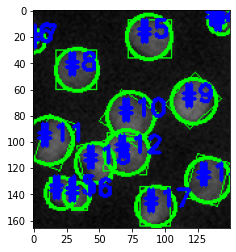

In [14]:
# loop over the unique labels returned by the Watershed
# algorithm
for label in np.unique(labels):
	# if the label is zero, we are examining the 'background'
	# so simply ignore it
	if label == 0:
		continue
	# otherwise, allocate memory for the label region and draw
	# it on the mask
	mask = np.zeros(gray.shape, dtype="uint8")
	mask[labels == label] = 255
	# detect contours in the mask and grab the largest one
	cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
		cv2.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)
	c = max(cnts, key=cv2.contourArea)
	# draw a circle enclosing the object
	((x, y), r) = cv2.minEnclosingCircle(c)
	cv2.circle(image, (int(x), int(y)), int(r), (0, 255, 0), 2)
	cv2.putText(image, "#{}".format(label), (int(x) - 10, int(y)),
		cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
# show the output image
plt.imshow(image)
cv2.waitKey(0)